# Hard Targeting for scanning Lidar North allignment

ForWind Oldenburg
Version 1.0

Contributing author: Andreas Rott


To understand the calculations and methods presented in this notebook it is highly recommended to read the corresponding publication: 
Rott, A., Schneemann, J., Theuer, F., Trujillo Quintero, J. J., and Kühn, M.: Alignment of scanning lidars in offshore wind farms, Wind Energ. Sci. Discuss. [preprint], https://doi.org/10.5194/wes-2021-62, in review, 2021.

Executed with Python 3.8.12

## Brief description
Code to calculate the North offset of a scanning wind lidar e.g. in an offshore location.
The lidar needs to measure in an area with hard targets like wind turbines or light houses with known locations.
The hard targets appear in the carrier to noise ratio (CNR) in the lidar data with a high backscatter.

To adapt this script to your specific location you need to give the file locations of
- a file containing the coordinates of the measured hard targets in a cartesian coordinate system (e.g. UTM)
- a data file with the hard target lidar scans

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
from scipy import signal

In [2]:
HardTargets_file_path = "https://sandbox.zenodo.org/record/954727/files/HardTargets_GTI.csv"
HardTarget_Scan_path = "https://sandbox.zenodo.org/record/955805/files/HT_scans_GTI.zip"

# Load hard target coordinates and Lidar location

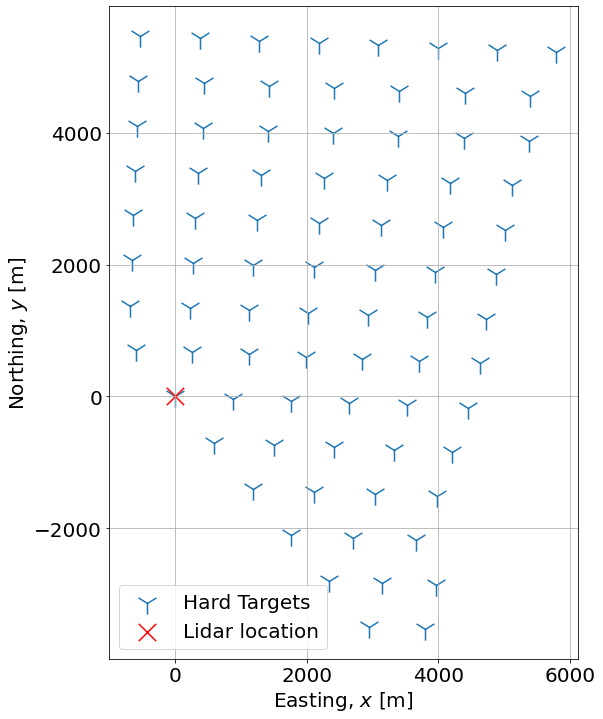

In [3]:
# Load Turbine Coordinates
## Choose your file containing hard target cartesian coordinates here, unit: [m]
## please make sure that the columns of the coordinates are named 'x' and 'y'

HardTargets = pd.read_csv(HardTargets_file_path,index_col=0)

## Set the location of your Lidar here using the cartesian coordinate system. In this example case the turbine was located at the Turbine 58 i.e. x=HardTargets.x[57], y = HardTargets.y[57].

LidarLocation = pd.DataFrame({'x':HardTargets.x[57], 'y':HardTargets.y[57]}, index=[0])

## Set the initial guess for your lidar orientation (deviation from North direction clockwise)

initial_guess_Lidar_orientation = 170

## Set the location of your lidar data here. The columns 'cnr', 'range' and 'azi' are used. Please make sure that all scans were performed with a scanning elevation of 0 deg.

Lidar = pd.read_pickle(HardTarget_Scan_path)

# Plot Hard targets and lidar locations
fontsize = 20 # set fontsize for plot
fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(HardTargets.x-LidarLocation.x[0],HardTargets.y-LidarLocation.y[0], s=500, marker='1', label='Hard Targets')
ax.scatter(0,0, c='r', s=300, marker='x', label='Lidar location')
ax.set_aspect('equal')
ax.set_xlabel('Easting, $x\ [\mathrm{m}]$', fontsize=fontsize)
ax.set_ylabel('Northing, $y\ [\mathrm{m}]$', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.grid(True)
ax.legend(fontsize=fontsize)

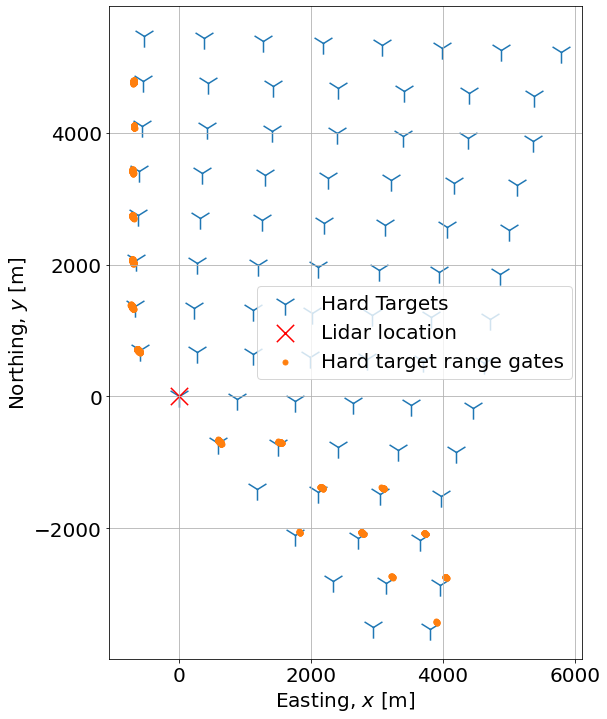

In [4]:
# Identify Hard Targets in lidar data via a cnr threshold
# Transform azi and range to x and y with initial guess of the misalignment

Lidar['x'] = np.sin((Lidar.azi+initial_guess_Lidar_orientation)*np.pi/180)*Lidar.range
Lidar['y'] = np.cos((Lidar.azi+initial_guess_Lidar_orientation)*np.pi/180)*Lidar.range

## Select hard targets by cnr threshold. As in the example below you can choose the threshold for different range intervals separately, if needed for close and distant hard targets in one run
# id_ht = ((Lidar.cnr>5) & (Lidar.range <=4000)) | ((Lidar.cnr>-5) & (Lidar.range >4000) & (Lidar.range <=9000))
id_ht = (Lidar.cnr>5) & (Lidar.range <7000) &(Lidar.y>-7/6*Lidar.x-200)

# If needed, you can separate non fixed hard targets like ships manually here. Further you can exclude data in sectors or ranges. Just exclude them from the boolian variable id_ht.
# Example:
# id_ht = id_ht & (Lidar.y>0)
# id_ht = id_ht & (Lidar.y<0)
# id_ht = id_ht & (Lidar.range<1000)

# Plot hard target range gates with initial guess over the turbines
fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(HardTargets.x-LidarLocation.x[0],HardTargets.y-LidarLocation.y[0], s=500, marker='1', label='Hard Targets')
ax.scatter(0,0, c='r', s=300, marker='x', label='Lidar location')
ax.scatter(Lidar[id_ht].x, Lidar[id_ht].y, c='C1', s=25, marker='o', zorder=1, label='Hard target range gates')

ax.set_aspect('equal')
ax.set_xlabel('Easting, $x\ [\mathrm{m}]$', fontsize=fontsize)
ax.set_ylabel('Northing, $y\ [\mathrm{m}]$', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.grid(True)
ax.legend(fontsize=fontsize)
plt.show()

# Optimization

In [5]:
# # Define inputs for cost function from lidar data
ht_azi = Lidar.azi[id_ht]
ht_range = Lidar.range[id_ht]

In [6]:
# Define cost function for optimization
def cost_function(params, ht_azi=ht_azi, ht_range=ht_range, HardTargets=HardTargets, show_plot=0):
    x_offset = params[0]
    y_offset = params[1]
    azi_offset = params[2]
    t_x = np.expand_dims(HardTargets.x.values, axis=1)
    t_y = np.expand_dims(HardTargets.y.values, axis=1)
    ht_x = np.array(np.sin((ht_azi+azi_offset)*np.pi/180)*ht_range+x_offset)
    ht_y = np.array(np.cos((ht_azi+azi_offset)*np.pi/180)*ht_range+y_offset)
    cost = np.sqrt((ht_x - t_x)**2 + (ht_y - t_y)**2)
    cost = np.min(cost, axis=0)
    if show_plot:
        fig,ax = plt.subplots(figsize=(16,16))
        ax.scatter(t_x.squeeze()-LidarLocation.x.values, t_y.squeeze()-LidarLocation.y.values, s=500, marker='1', label='Hard Targets')
        ax.scatter(ht_x-LidarLocation.x[0], ht_y-LidarLocation.y[0], s=25, marker='o', zorder=1, label='Hard target range gates')
        ax.scatter(0,0, c='r', s=300, marker='x', label='Lidar location')        
        ax.set_aspect('equal')
        ax.set_xlabel('Easting, $x\ [\mathrm{m}]$', fontsize=fontsize)
        ax.set_ylabel('Northing, $y\ [\mathrm{m}]$', fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.grid(True)
        ax.legend(fontsize=fontsize)
    return np.linalg.norm(cost)

x_offset = -3.9
y_offset = -4.3
North_offset = 171.65°


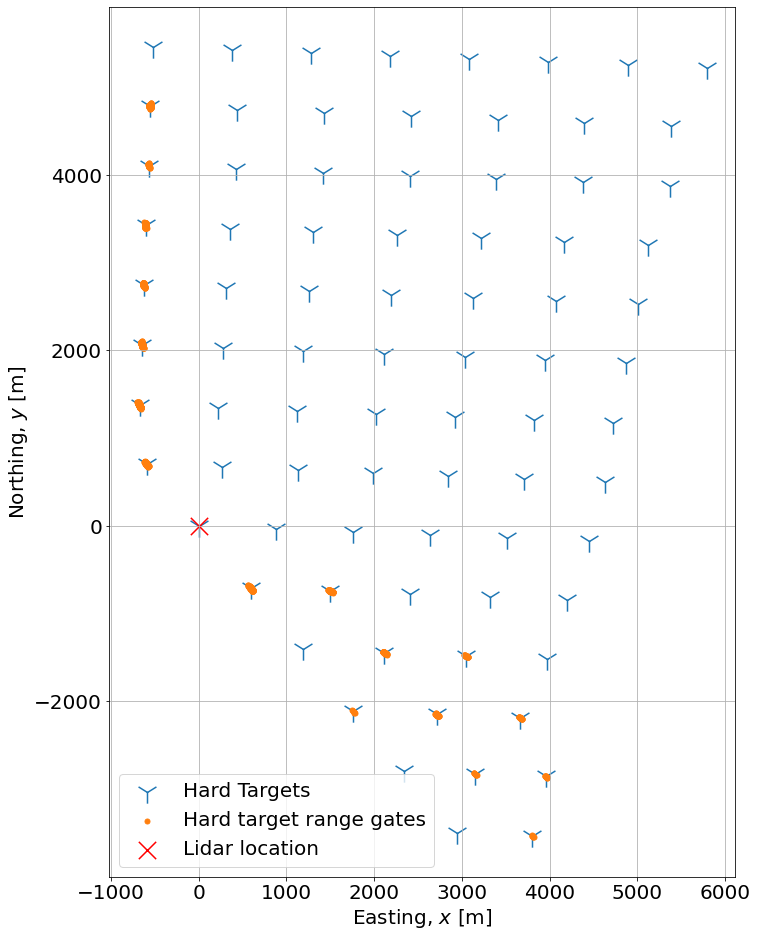

In [7]:
initial_params = [LidarLocation.x[0],LidarLocation.y[0], initial_guess_Lidar_orientation]
result = minimize(cost_function,initial_params,method='Nelder-Mead')
# print(result)
cost_function(result.x,show_plot=1)
print('x_offset = {:2.2}'.format(result.x[0]-LidarLocation.x[0]) )
print('y_offset = {:2.2}'.format(result.x[1]-LidarLocation.y[0]) )
print('North_offset = {:3.2f}\N{DEGREE SIGN}'.format(result.x[2]) )